<a href="https://colab.research.google.com/github/alberba/Aprendizaje-Autom-tico/blob/main/18_Practica2/detectsegm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
from collections import defaultdict
from pathlib import Path
from PIL import Image
from torchvision.ops.boxes import masks_to_boxes
from torch.utils.data import Dataset
import os
import cv2
import scipy.io
import numpy as np
import torch
import pylab as pl
from IPython import display
from torchvision.transforms.v2 import functional as F
from torchvision.transforms import v2 as T
from torchvision import tv_tensors
from tqdm.auto import tqdm
import torch.optim as optim
import torchvision
import random
from torchvision import transforms, datasets
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from google.colab.patches import cv2_imshow

In [2]:
dataset = datasets.Caltech101(root='./dataAux', download=True, target_type='annotation')

Files already downloaded and verified


In [3]:
def process_images_and_masks(base_dir_images, base_dir_annotations):
    """
    Procesa imágenes y máscaras de las clases 'buddha' y 'dalmatian'.

    Args:
        base_dir_images (str): Ruta base de las imágenes (101_ObjectCategories).
        base_dir_annotations (str): Ruta base de las anotaciones.

    Returns:
        list: Lista de imágenes procesadas como arrays de NumPy.
        list: Lista de máscaras procesadas como arrays de NumPy.
    """
    classes_to_process = {'buddha': 1, 'dalmatian': 2}
    image_list = []
    mask_list = []
    class_list = []

    for class_name, class_id in classes_to_process.items():
        # Rutas de las subcarpetas
        class_images_dir = os.path.join(base_dir_images, class_name)
        class_annotations_dir = os.path.join(base_dir_annotations, class_name)

        # Verifica si las carpetas existen
        if not os.path.isdir(class_images_dir) or not os.path.isdir(class_annotations_dir):
            print(f"Carpeta no encontrada: {class_name}")
            continue

        # Procesar las imágenes y las anotaciones
        for annotation_file in os.listdir(class_annotations_dir):
            if annotation_file.endswith('.mat'):
                annotation_path = os.path.join(class_annotations_dir, annotation_file)
                annotation_id = os.path.splitext(annotation_file)[0].split('_')[-1]

                # Ruta de la imagen correspondiente
                image_file = f"image_{annotation_id}.jpg"
                image_path = os.path.join(class_images_dir, image_file)

                if not os.path.exists(image_path):
                    print(f"Imagen no encontrada para {annotation_file}")
                    continue

                # Cargar la anotación
                mat_data = scipy.io.loadmat(annotation_path)
                if 'obj_contour' not in mat_data:
                    print(f"'obj_contour' no encontrada en {annotation_file}")
                    continue

                obj_contour = mat_data['obj_contour']  # Contorno de la máscara

                # Cargar la imagen
                image = cv2.imread(image_path)
                if image is None:
                    print(f"Error al cargar la imagen {image_path}")
                    continue

                # Crear una máscara vacía del mismo tamaño que la imagen
                mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
                boxcoord = mat_data['box_coord'].flatten()

                # Dibujar el contorno en la máscara
                contour_points = np.transpose(obj_contour)  # Shape (Y, 2)
                contour_points[:, 0] += boxcoord[2]  # Ajustar X según x0 del bounding box
                contour_points[:, 1] += boxcoord[0]  # Ajustar Y según y0 del bounding box
                contour_points = contour_points.astype(np.int32)  # Asegurar tipo correcto

                cv2.drawContours(mask, [contour_points], contourIdx=-1, color=1, thickness=-1)
                #cv2.drawContours(image, [contour_points], contourIdx=-1, color=1, thickness=-1)

                # Mostrar la imagen
                # cv2_imshow(image)
                # cv2.waitKey(0)
                # cv2.destroyAllWindows()

                # Agregar la imagen y la máscara a las listas
                image_list.append(image)
                mask_list.append(mask)
                class_list.append(class_id)

    return image_list, mask_list, class_list

base_dir_images = "./dataAux/caltech101/101_ObjectCategories"
base_dir_annotations = "./dataAux/caltech101/Annotations"
images, masks, classes = process_images_and_masks(base_dir_images, base_dir_annotations)
print(f"Procesadas {len(images)} imágenes y {len(masks)} máscaras.")


Procesadas 152 imágenes y 152 máscaras.


In [4]:
def augment_data(images, masks, classes):
    """
    Realiza aumentos de datos en las imágenes y máscaras.

    Args:
        images (list): Lista de imágenes como arrays de NumPy.
        masks (list): Lista de máscaras como arrays de NumPy.

    Returns:
        list: Lista de imágenes aumentadas como arrays de NumPy.
        list: Lista de máscaras aumentadas como arrays de NumPy.
    """
    augmented_images = []
    augmented_masks = []
    augmented_classes = []

    common_transform = [
        # 1) Ajuste del tamaño a 256x256
        transforms.Resize((256, 256)),

        # 2) Recorte aleatorio para 224x224, simulando diferentes encuadres/zoom
        transforms.RandomResizedCrop(
            size=256,
            scale=(0.8, 1.0),       # rango de escalado
            ratio=(0.9, 1.1)        # rango de aspecto (ancho x alto)
        ),

        # 3) Rotación aleatoria moderada (±15 grados)
        transforms.RandomRotation(degrees=30),

        # 4) Flip horizontal aleatorio (probabilidad 0.5)
        transforms.RandomHorizontalFlip(p=1),
    ]

    # Transformaciones para imágenes
    img_transform = transforms.Compose(common_transform + [

        # 5) Ajustes de color para simular distintas condiciones de iluminación
        transforms.ColorJitter(
            brightness=0.5,
            contrast=0.2,
            saturation=0.4,
            hue=0.05
        ),
    ])

    mask_transform = transforms.Compose(common_transform)

    num_nuevas_por_imagen = 2
    for img, mask, img_class in zip(images, masks, classes):
        # Convertir la imagen y la máscara a PIL
        img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        mask_pil = Image.fromarray(mask)

        for i in range(num_nuevas_por_imagen):

            # Aplicar las transformaciones
            seed = random.randint(0, 2**32)  # Para asegurar que las mismas transformaciones se aplican a ambos
            random.seed(seed)
            augmented_img = img_transform(img_pil)
            random.seed(seed)
            augmented_mask = mask_transform(mask_pil)

            # Convertir de nuevo a arrays de NumPy
            augmented_images.append(np.array(augmented_img))
            augmented_masks.append(np.array(augmented_mask))
            augmented_classes.append(img_class)

    return augmented_images, augmented_masks, augmented_classes

augmented_images, augmented_masks, augmented_classes = augment_data(images, masks, classes)


In [5]:
class CustomDataset(Dataset):
    """
    Dataset personalizado para imágenes y máscaras, compatible con Mask R-CNN.
    """
    def __init__(self, images, masks, classes, transforms=None):
        """
        Inicializa el dataset.

        Args:
            images (list): Lista de imágenes como arrays de NumPy.
            masks (list): Lista de máscaras como arrays de NumPy.
            classes (list): Lista de etiquetas de clase correspondientes.
            transform (callable, optional): Transformaciones a aplicar a las imágenes y máscaras.
        """
        self.images = images
        print(len(images))
        self.masks = masks
        self.classes = classes
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        mask = np.expand_dims(mask, axis=0)  # Añadir canal para compatibilidad con Torch
        mask = torch.Tensor(mask)
        label = self.classes[idx]

        num_objs = 1

        # Crear el target para Mask R-CNN
        boxes = masks_to_boxes(mask)
        area = (boxes[0][2] - boxes[0][0]) * (boxes[0][3] - boxes[0][1])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        img = tv_tensors.Image(image)


        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(
            boxes, format="XYXY", canvas_size=F.get_size(img)
        )
        target["masks"] =  tv_tensors.Mask(mask)
        target["labels"] = torch.tensor([label], dtype=torch.int64)
        target["image_id"] = idx
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

In [6]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [7]:
BATCH_SIZE = 16

transforms = T.Compose(
    [
        T.ToDtype(torch.float, scale=True),
        T.ToPureTensor(),
    ]
)

dataset = CustomDataset(augmented_images, augmented_masks, augmented_classes, transforms)

train_data, test_data = torch.utils.data.random_split(dataset, [0.7, 0.3])

# define training and validation data loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn
)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn
)

304


In [8]:
def get_model_instance_segmentation(num_classes):
  model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
  in_features = model.roi_heads.box_predictor.cls_score.in_features

  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
  hidden_layer = model.roi_heads.mask_predictor.conv5_mask.out_channels

  # and replace the mask predictor with a new one
  model.roi_heads.mask_predictor = MaskRCNNPredictor(
      in_features_mask, hidden_layer, num_classes
  )

  return model

<Figure size 640x480 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

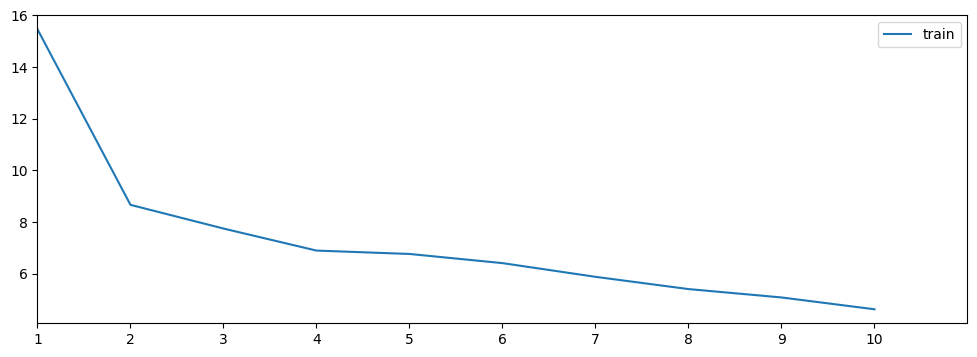

In [9]:
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = get_model_instance_segmentation(3)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

t_loss = np.zeros(epochs)

pbar = tqdm(range(1, epochs + 1))  # tdqm permet tenir text dinàmic

for epoch in pbar:

    train_loss = 0
    val_loss = 0
    model.train()

    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [
            {
                k: v.to(device) if isinstance(v, torch.Tensor) else v
                for k, v in t.items()
            } for t in targets
        ]

        images = [image.permute(2, 0, 1) for image in images]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())


        optimizer.zero_grad()
        train_loss += losses.item()
        losses.backward()
        optimizer.step()

    t_loss[epoch - 1] = train_loss


    pl.clf()
    pl.figure(figsize=(12, 4))
    pl.plot(t_loss[:epoch], label="train")
    pl.legend()
    pl.xlim(0, epochs)
    pl.xticks(range(0, epochs, 1), range(1, epochs + 1, 1))

    display.display(pl.gcf())
    display.clear_output(wait=True)

In [12]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_segmentation_masks, draw_bounding_boxes

torch.cuda.empty_cache()
print(torch.cuda.memory_summary(device=torch.device('cuda'), abbreviated=True))
num_batches_to_display = 2
batches_displayed = 0
model.eval()
test_list = list(test_loader)

for images, targets in train_loader:
    images = list(image.to(device) for image in images)
    targets = [
        {
            k: v.to(device) if isinstance(v, torch.Tensor) else v
            for k, v in t.items()
        } for t in targets
    ]

    images = [image.permute(2, 0, 1) for image in images]
    res = model(images)

    for i in range(len(images)):
      drawn_boxes = draw_bounding_boxes(images[i], res[i]["boxes"], colors="red")
      mask_superposed = (
          draw_segmentation_masks(
              images[i], masks=(res[i]["masks"][0, 0, :, :] > 0.1), alpha=0.8, colors="blue"
          )
          .detach()
          .cpu()
      )
      fig, ax = plt.subplots(1, 2, figsize=(15, 15))
      ax[0].imshow(mask_superposed.permute(1, 2, 0))
      ax[0].imshow(drawn_boxes.permute(1, 2, 0).cpu().numpy());
      plt.show()


# while batches_displayed < num_batches_to_display:
#     images = list(image.to(device) for image in images)
#     images = [image.permute(2, 0, 1) for image in images]
#     print(images[0].shape)

#     # Predicción
#     res = model(images)

#     # Calcular el número de filas necesarias
#     num_images = len(images) * 2
#     num_cols = 4
#     num_rows = (num_images + num_cols - 1) // num_cols  # Redondear hacia arriba

#     fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
#     axes = axes.flatten()  # Aplanar la matriz de ejes para iterar fácilmente

#     for i, (img, ax) in enumerate(zip(res, axes)):
#         mask_superposed = (
#             draw_segmentation_masks(
#                 img, masks=(res[0]["masks"][0, 0, :, :] > 0.1), alpha=0.8, colors="blue"
#             )
#             .detach()
#             .cpu()
#         )

#         drawn_boxes = draw_bounding_boxes(img, res[0]["boxes"], colors="red")
#         ax.imshow(mask_superposed.permute(1, 2, 0))
#         ax.imshow(drawn_boxes.permute(1, 2, 0).cpu().numpy());

#     # Ocultar los ejes sobrantes si hay menos imágenes que espacios
#     for ax in axes[num_images:]:
#         ax.axis("off")

#     plt.tight_layout()  # Ajustar los espacios en el plot
#     plt.show()

#     batches_displayed += 1

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 2            |        cudaMalloc retries: 3         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  14393 MiB |  14515 MiB |  12177 GiB |  12163 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  14393 MiB |  14515 MiB |  12177 GiB |  12163 GiB |
|---------------------------------------------------------------------------|
| Requested memory      |  14370 MiB |  14491 MiB |  12157 GiB |  12143 GiB |
|---------------------------------------------------------------

OutOfMemoryError: CUDA out of memory. Tried to allocate 626.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 83.06 MiB is free. Process 406159 has 14.66 GiB memory in use. Of the allocated memory 14.19 GiB is allocated by PyTorch, and 348.15 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)